<h1 align="center">Projet Final MDI 721 : Analyse du Vendée Globe 2020 - 2021</h1>
<h3 align="right">Roland SCHWARTZ<br><i>MS IA - 2021/2022</i></h3>

## Initialisation du projet

### Import des librairies

In [1]:
import os
import re

import requests
from bs4 import BeautifulSoup

import xlwings as xw

from IPython.display import display, Image, HTML, clear_output
import ipywidgets as widgets
from ipyleaflet import Map, Marker, AntPath, basemaps

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Définition des URL sources et répertoire local

In [21]:
URL_CLASS = 'https://www.vendeeglobe.org/fr/classement'
URL_GLOSS = 'https://www.vendeeglobe.org/fr/glossaire'

#DIR_XL = 'test_excel//'
#DIR_XL = 'dir_excel//'
DIR_XL = 'dir_excel'

## Extraction des données

### Download des fichiers Excel sur l'intégralité de la course

In [22]:
def get_all_XL(URL_CLASS, DIR_XL):

    if DIR_XL in os.listdir():
        len_dir = len(os.listdir('./'+DIR_XL))
        if len_dir > 0:
            print(f'Le dossier local contient déjà {len_dir} éléments : les fichiers XL ne seront pas téléchargés.')
            return
    else:
        os.mkdir(DIR_XL)
        
    res = requests.get(URL_CLASS)
    soup = BeautifulSoup(res.content, 'html.parser')

    excel_app = xw.App(visible=False)

    options = soup.find("select").find_all("option")
    idx = 0

    for option in options[1:-2]:
        tag_xl = option.attrs['value']+'.xlsx'
        path_xl = DIR_XL+'/'+tag_xl
        url_xl = 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_'+tag_xl
        r_xl = requests.get(url_xl)
        open(path_xl, 'wb').write(r_xl.content)
        excel_book = excel_app.books.open(path_xl)
        excel_book.save()
        excel_book.close()
        idx += 1
        if (idx%100 == 0):
            print(f'Avancement : {idx} / {len(options[1:-2])}')

    excel_app.quit()

    return

In [23]:
get_all_XL(URL_CLASS, DIR_XL)

Le dossier local contient déjà 702 éléments : les fichiers XL ne seront pas téléchargés.


### Récupération et aggrégation des informations sur les bateaux & skippers

In [241]:
res_nav = requests.get(URL_GLOSS)

soup_nav = BeautifulSoup(res_nav.content, 'html.parser')

spec_boat_all = soup_nav.find_all(class_="sv-u-1 sv-u-s-1-2 sv-u-m-1-3 sv-u-l-1-6")

list_spec = []
max_prog_nav = len(spec_boat_all)
idx_prog = 0

w_prog_nav = widgets.IntProgress(
    value=0,
    min=0,
    max=max_prog_nav,
    step=1,
    description='Progress :',
    bar_style='info', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal',
)

display(w_prog_nav)

for spec_boat in spec_boat_all:
    row = {}
    row['Skipper'] = spec_boat.find('span').text
    row['Nom du bateau'] = spec_boat.find('h3').text

    for spec in spec_boat.find_all("li"):
        row[spec.text.split(' : ')[0]] = spec.text.split(' : ')[1]

    url_skipper = 'https://www.vendeeglobe.org'+spec_boat.find(class_='boats-list__popup-skipper-link')['href']

    res_skipper = requests.get(url_skipper)
    soup_skipper = BeautifulSoup(res_skipper.content, 'html.parser')

    row['Nationalité du Skipper'] = soup_skipper.find(class_="skipper-datalist__item m--nationality").find(class_="skipper-datalist__value__text").text
    row['Age du Skipper'] = soup_skipper.find(class_="icon icon-calendar").find_parent("p").find(class_="skipper-datalist__value__text").text.split()[0]
    row['Nb. participations du Skipper au Vendée'] = int(soup_skipper.find(class_="skipper-participation__number").find("span").text)
    
    skipper_all_palmares = soup_skipper.find_all(class_='prizes-slider__year')
    cpt_palma = 0
    for year in skipper_all_palmares:
        list_palma_y = year.find_parent('div').find(class_='prizes-slider__list l-unlist').text.split('\r\n')
        cpt_palma += len(list_palma_y) - 1
    
    row['Nb. Palmarès du Skipper'] = cpt_palma

    row['URL Page Skipper'] = url_skipper
    row['URL Photo Skipper'] = 'https://www.vendeeglobe.org'+soup_skipper.find(class_='skipper-hero__figure__img svg-filter').image['xlink:href']
    row['URL Icône bateau'] = 'https://www.vendeeglobe.org'+spec_boat.find('img')['src']

    list_spec.append(row)
    idx_prog += 1
    w_prog_nav.value = idx_prog

if w_prog_nav.value == max_prog_nav:
    w_prog_nav.bar_style = 'success'
    w_prog_nav.description = 'Done !'

df_boat = pd.DataFrame(list_spec)
df_boat.head()



IntProgress(value=0, bar_style='info', description='Downloading skipper infos :', max=33)

,Skipper,Nom du bateau,Numéro de voile,Anciens noms du bateau,Architecte,Chantier,Date de lancement,Longueur,Largeur,Tirant d'eau,...,Voile quille,Surface de voiles au près,Surface de voiles au portant,Nationalité du Skipper,Age du Skipper,Nb. participations du Skipper au Vendée,Nb. Palmarès du Skipper,URL Page Skipper,URL Photo Skipper,URL Icône bateau
0,Fabrice AMEDEO,NEWREST - ART & FENÊTRES,FRA 56,"No Way Back, Vento di Sardegna",VPLP/Verdier,Persico Marine,01 Août 2015,"18,28 m","5,85 m","4,50 m",...,monotype,320 m2,570 m2,FR,43,2,18,https://www.vendeeglobe.org/fr/skippers/93/fab...,https://www.vendeeglobe.org/medias/05/02/50238...,https://www.vendeeglobe.org/medias/05/08/50821...
1,Romain ATTANASIO,PURE - Best Western®,FRA 49,"Gitana Eighty, Synerciel, Newrest-Matmut",Bruce Farr Design,Southern Ocean Marine (Nouvelle Zélande),08 Mars 2007,"18,28m","5,80m","4,50m",...,acier forgé,280 m2,560 m2,FR,44,2,12,https://www.vendeeglobe.org/fr/skippers/110/ro...,https://www.vendeeglobe.org/medias/05/03/50390...,https://www.vendeeglobe.org/medias/05/06/50663...
2,Alexia BARRIER,TSE - 4MYPLANET,FRA72,"Famille Mary-Etamine du Lys, Initiatives Coeur...",Marc Lombard,MAG France,01 Mars 1998,"18,28m","5,54m","4,50m",...,acier,260 m2,580 m2,FR,41,1,19,https://www.vendeeglobe.org/fr/skippers/100/al...,https://www.vendeeglobe.org/medias/05/06/50614...,https://www.vendeeglobe.org/medias/05/04/50477...
3,Yannick BESTAVEN,Maître CoQ IV,17,Safran 2 - Des Voiles et Vous,Verdier - VPLP,CDK Technologies,12 Mars 2015,"18,28 m","5,80 m","4,50 m",...,acier mécano soudé,310 m2,550 m2,FR,48,2,17,https://www.vendeeglobe.org/fr/skippers/91/yan...,https://www.vendeeglobe.org/medias/05/05/50512...,https://www.vendeeglobe.org/medias/05/08/50815...
4,Jérémie BEYOU,CHARAL,08,NaN,VPLP,CDK Technologies,18 Août 2018,"18,28 m","5,85 m","4,50 m",...,acier,320 m2,600 m2,FR,45,4,26,https://www.vendeeglobe.org/fr/skippers/103/je...,https://www.vendeeglobe.org/medias/05/50/55058...,https://www.vendeeglobe.org/medias/05/04/50486...


## Préparation des données

### Nettoyage et formatage des données Skipper

In [8]:
def str2float(str_XL):
    #return float(re.findall(pattern='[-+]?\d*[\.|,]\d+|\d+', string=str_XL.replace(',','.'))[0])
    if (str_XL is None or len(str_XL) == 0):
        floatconv = None
    else:
        #print(str_XL)
        floatconv = float(re.search(pattern='[-+]?\d*[\.|,]\d+|\d+', string=str_XL.replace(',','.')).group(0))
    return floatconv


def dm2float(str_dms):
    if (str_dms is None or len(str_dms) == 0):
        floatconv = None
    else:
        deg, minutes, direction =  re.split('[°\']', str_dms)
        floatconv = (float(deg) + float(minutes)/60) * (-1 if direction in ['W', 'S'] else 1)
    return floatconv

def natsail2int(str_id):
    #return int(re.findall(pattern='\d+', string=str_id)[0])
    if (str_id is None or len(str_id) == 0):
        invconv = None
    else:
        invconv = int(re.search(pattern='\d+', string=str_id).group(0))
    return invconv

str_XL = '554m'
str_XL = ''
print(f'var conv : {str2float(str_XL)} de type : {type(str2float(str_XL))}')

#str_dms = df_course_test.iloc[10]['Latitude']
str_dms = '29°28.03\'N'
print(f'var conv : {dm2float(str_dms)} de type : {type(dm2float(str_dms))}')

str_id = '\nFR\nFRA 02'
print(f'var conv : {natsail2int(str_id)} de type : {type(natsail2int(str_id))}')

var conv : None de type : <class 'NoneType'>
var conv : 29.467166666666667 de type : <class 'float'>
var conv : 2 de type : <class 'int'>


### Nettoyage, formatage et aggrégation des données de la course

In [9]:
col_names = ['Rang', 'Numéro Voile', 'Latitude', 'Longitude', 
			'Cap sur 30 min', 'Vitesse sur 30 min (kts)',
			'VMG sur 30 min (kts)', 'Distance sur 30 min (nm)', 
			'Cap depuis dernier classement', 'Vitesse depuis dernier classement (kts)',
			'VMG depuis dernier classement (kts)', 'Distance depuis dernier classement (nm)',
			'Cap sur 24h', 'Vitesse sur 24h (kts)', 'VMG sur 24h (kts)', 'Distance sur 24h (nm)',
			'Distance restante (nm)', 'Distance au premier (nm)']

col_conv = ['Vitesse sur 30 min (kts)', 'VMG sur 30 min (kts)', 'Distance sur 30 min (nm)',
			'Vitesse depuis dernier classement (kts)', 'VMG depuis dernier classement (kts)',
			'Distance depuis dernier classement (nm)', 'Vitesse sur 24h (kts)', 'VMG sur 24h (kts)',
			'Distance sur 24h (nm)', 'Distance restante (nm)', 'Distance au premier (nm)']

dico_conv = dict.fromkeys(col_conv, str2float)
dico_conv.update(dict.fromkeys(['Latitude', 'Longitude'], dm2float))
dico_conv['Numéro Voile'] = natsail2int

In [10]:
# df_course_test = pd.read_excel('./DIR_XL/20201114_080000.xlsx')

xl_file_test = '20201125_040000.xlsx'

df_course_test = pd.read_excel('./'+DIR_XL+xl_file_test, converters=dico_conv, na_values=['','\n','\\n'], usecols='B,C,F:U', skiprows=5, skipfooter=4, header=None, names=col_names)
#df_course_test = pd.read_excel('./'+DIR_XL+xl_file_test, usecols='B,C,F:U', skiprows=5, skipfooter=4, header=None, names=col_names)
# df_course_test[col_conv].str.extract('[-+]?\d*[\.|,]\d+|\d+')



df_course_test.tail(10)

,Rang,Numéro Voile,Latitude,Longitude,Cap sur 30 min,Vitesse sur 30 min (kts),VMG sur 30 min (kts),Distance sur 30 min (nm),Cap depuis dernier classement,Vitesse depuis dernier classement (kts),VMG depuis dernier classement (kts),Distance depuis dernier classement (nm),Cap sur 24h,Vitesse sur 24h (kts),VMG sur 24h (kts),Distance sur 24h (nm),Distance restante (nm),Distance au premier (nm)
23,24,2,-4.564333,-33.487000,190°,16.4,13.4,8.2,191°,15.2,12.6,106.4,196°,13.0,10.6,312.2,21081.5,2058.7
24,25,72,3.068333,-28.367667,203°,10.1,8.1,5.0,202°,5.6,4.6,38.9,200°,5.3,4.6,128.0,21416.3,2393.5
25,26,56,2.900167,-29.423167,236°,1.1,0.4,0.6,203°,2.3,1.8,16.2,183°,3.9,3.7,93.2,21421.6,2398.8
26,27,50,3.204000,-28.508333,181°,2.8,2.7,1.4,196°,5.1,4.5,36.0,179°,4.7,4.6,112.1,21426.2,2403.3
27,28,83,3.564667,-27.868167,222°,9.3,5.5,4.7,198°,3.8,3.3,26.5,171°,4.1,4.1,99.1,21438.9,2416.0
28,29,222,4.194833,-27.828833,225°,8.0,4.4,4.0,212°,3.6,2.6,24.9,190°,3.3,3.1,79.6,21475.4,2452.6
29,30,69,4.691167,-28.781500,195°,6.6,5.8,3.3,186°,6.2,5.8,43.1,201°,1.5,1.3,36.5,21516.8,2494.0
30,31,11,6.991667,-28.896167,175°,6.9,6.9,3.5,177°,6.7,6.6,46.7,167°,3.2,3.2,76.4,21653.0,2630.2
31,32,8,14.488833,-22.069000,272°,10.3,1.7,5.1,198°,7.5,7.5,52.8,201°,8.5,8.4,204.1,22084.5,3061.6
32,RET,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Présentation synthétique des duos Skipper / IMOCA

## Analyse des données de la course

### VMG vs. Vitesse réelle

### Expérience des skippers et performance

### Caractéristiques de l'IMOCA et performance

# BROUILLON TO REMOVE

## Tests widgets

### Display loading bar

In [240]:
max_iter = 10_000

w_prog_XL = widgets.IntProgress(
    value=0,
    min=0,
    max=max_iter,
    step=1,
    description='Downloading:',
    bar_style='info', # 'success', 'info', 'warning', 'danger' or ''
    orientation='horizontal',
)

display(w_prog_XL)

for i in range(max_iter + 1):
    w_prog_XL.value = i

if w_prog_XL.value == max_iter:
    w_prog_XL.bar_style = 'success'
    w_prog_XL.description = 'Done !'




IntProgress(value=0, bar_style='info', description='Downloading:', max=10000)

In [ ]:
int_range = widgets.IntSlider()
output2 = widgets.Output()

display(int_range, output2)

test_suivi = 0

def on_value_change(change):
    with output2:
        print(str(change))
        globals()['test_suivi'] += 1
        suivi = globals()['test_suivi']
        print(f'test suivi : {suivi}')

int_range.observe(on_value_change, names='value')

In [253]:
test_suivi = 0

globals()['test_suivi']+=1

test_suivi

1

### Display Skipper / IMOCA info

In [183]:
#file = open("https://www.vendeeglobe.org/medias/05/02/50238/fabrice-amedeo-c-462-560.jpg", "rb")
#image = file.read()
url_image_test = "https://www.vendeeglobe.org/medias/05/02/50238/fabrice-amedeo-c-462-560.jpg"
imgtestdisp = Image(url_image_test)


widgets.Image(
    value=imgtestdisp.data,
    format='jpg',
    width=300,
    height=400,
)



Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x00`\x00`\x00\x00\xff\xfe\x00;CREATOR: gd-jpeg v1.0…

In [45]:
list_skipper = df_boat['Skipper'].tolist()

skipper_select = widgets.Dropdown(options=list_skipper)

display(skipper_select)

Dropdown(options=('Fabrice AMEDEO', 'Romain ATTANASIO', 'Alexia BARRIER', 'Yannick BESTAVEN', 'Jérémie BEYOU',…

# WIDGET ENFIN FONCTIONNEL !!!!!

In [190]:
skipper_select = widgets.Dropdown(options=list_skipper)

data_img = Image(df_boat['URL Photo Skipper'][df_boat['Skipper'] == skipper_select.value].values[0]).data

skipper_img_widg = widgets.Image(value=data_img, format='jpg', width=300, height=400)
output2 = widgets.Output()

def handle_skipper_chg(change):
    new_url = df_boat['URL Photo Skipper'][df_boat['Skipper'] == change.new].values[0]
    skipper_img_widg.value = Image(new_url).data

skipper_select.observe(handle_skipper_chg, names='value')

widgets.VBox([skipper_select, skipper_img_widg])


In [257]:
hbox_layout = widgets.Layout()
#hbox_layout.width = '100%'
hbox_layout.justify_content = 'space-around'

black_box_layout = widgets.Layout()
black_box_layout.width = '400px'
black_box_layout.height = '400px'
black_box_layout.border = '5px solid black'

fit_opt = 'contain'
image_margin = '0 0 0 0'


list_skipper = df_boat['Skipper'].tolist()
skipper_select = widgets.Dropdown(options=list_skipper)

html_boat = '<h2 align="center"><i>'+df_boat['Nom du bateau'][df_boat['Skipper'] == skipper_select.value].values[0]+'</i></h2>'
title_boat = widgets.HTML(value=html_boat)

data_img = Image(df_boat['URL Photo Skipper'][df_boat['Skipper'] == skipper_select.value].values[0]).data
#skipper_img_widg = widgets.Image(value=data_img, format='jpg', width=300, height=400)
skipper_img_widg = widgets.Image(value=data_img, format='jpg')

data_boat_img = Image(df_boat['URL Icône bateau'][df_boat['Skipper'] == skipper_select.value].values[0]).data
#boat_img_widg = widgets.Image(value=data_boat_img, format='jpg', width=300, height=400)
boat_img_widg = widgets.Image(value=data_boat_img, format='jpg')

def handle_skipper_chg(change):
    df_skipper = df_boat[df_boat['Skipper'] == change.new]
    new_url_skip = df_skipper['URL Photo Skipper'].values[0]
    skipper_img_widg.value = Image(new_url_skip).data
    new_url_boat = df_skipper['URL Icône bateau'].values[0]
    boat_img_widg.value = Image(new_url_boat).data
    new_html_boat = '<h2 align="center"><i>'+df_skipper['Nom du bateau'].values[0]+'</i></h2>'
    title_boat.value = new_html_boat


skipper_select.observe(handle_skipper_chg, names='value')


skipper_img_widg.layout.object_fit = fit_opt
boat_img_widg.layout.object_fit = fit_opt
skipper_img_widg.layout.margin = image_margin
boat_img_widg.layout.margin = image_margin
skipper_img_widg.layout.object_position = 'center center'
boat_img_widg.layout.object_position = 'center center'

box_img_skip = widgets.Box([skipper_img_widg])
box_img_skip.layout = black_box_layout
box_img_skip.layout.object_position = 'center center'

box_img_boat = widgets.Box([boat_img_widg])
box_img_boat.layout = black_box_layout
box_img_boat.layout.object_position = 'center center'

left_box = widgets.VBox([skipper_select, box_img_skip])
left_box.layout.align_items = 'center'
right_box = widgets.VBox([title_boat, box_img_boat])
right_box.layout.align_items = 'center'
disp_widg = widgets.HBox([left_box, right_box])
disp_widg.layout = hbox_layout
disp_widg.layout.align_items = 'center'
disp_widg

In [220]:
df_boat['URL Photo Skipper'][df_boat['Skipper'] == skipper_select.value].values[0]

'https://www.vendeeglobe.org/medias/05/02/50243/arnaud-boissieres-c-462-560.jpg'

In [227]:
df_skipper = df_boat[df_boat['Skipper'] == skipper_select.value]

df_skipper['URL Photo Skipper'].values[0]

'https://www.vendeeglobe.org/medias/05/03/50390/romain-attanasio-c-462-560.jpg'

In [117]:
def path_to_image_html(path):
    '''
     This function essentially convert the image url to 
     '<img src="'+ path + '"/>' format. And one can put any
     formatting adjustments to control the height, aspect ratio, size etc.
     within as in the below example. 
    '''
    return '<img src="'+ path + '" style=max-height:500px;"/>'

def show_im():
    CSS = """
    .output {
        flex-direction: row;
    }
    """
    return HTML('<style>{}</style>'.format(CSS))

imgurl = df_boat['URL Photo Skipper'][df_boat['Skipper'] == skipper_select.value].values[0]

# display(HTML(path_to_image_html(imgurl)))
HTML(path_to_image_html(imgurl))

In [174]:
def image_viewer(drpdwn):
    
    imgurl = df_boat['URL Photo Skipper'][df_boat['Skipper'] == drpdwn].values[0]
    display(HTML(path_to_image_html(imgurl)))
    #show_im()


skipper_select = widgets.Dropdown(options=list_skipper, description='Skipper : ')

tab_nest = widgets.Tab()
tab_nest.set_title(0, 'Image Skipper')

f1 = widgets.interactive(image_viewer, drpdwn=skipper_select)

tab_nest.children = [widgets.VBox(children = f1.children)]
tab_nest

In [175]:
def image_viewer(drpdwn):
    
    imgurl = df_boat['URL Photo Skipper'][df_boat['Skipper'] == drpdwn].values[0]
    display(HTML(path_to_image_html(imgurl)))
    #show_im()


skipper_select = widgets.Dropdown(options=list_skipper, description='Skipper : ')

f1 = widgets.interactive(image_viewer, drpdwn=skipper_select)

wVBox = widgets.VBox(children = f1.children)
wVBox

In [164]:
w = widgets.Dropdown(
    options=['Addition', 'Multiplication', 'Subtraction', 'Division'],
    value='Addition',
    description='Task:',
)

out = widgets.Output()
clear_output()

i = 0

def on_change(change):
    clear_output()
    with out :
        #print("changed to %s" % change['new'])
        globals()['i'] += 1
        new_i = globals()['i']
        print(f'dico change : {change.old} to {change.new} - iter : {new_i}')


w.observe(on_change, names='value')
display(w, out, clear=True)


Dropdown(description='Task:', options=('Addition', 'Multiplication', 'Subtraction', 'Division'), value='Additi…

Output()

In [176]:
output_radio_selected = widgets.Text() # Used to take the user input and access it when needed
radio_input = widgets.RadioButtons(options=['Option 1', 'Option 2']) # Declare the set of radio buttons and provide options

out = widgets.Output()
clear_output()

def bind_selected_to_output(sender): # Connect the input from the user to the output so we can access it
    print(sender)
    global selected_option # Global variable to hold the user input for reuse in your code
    output_radio_selected.value = radio_input.value
    selected_option = output_radio_selected.value # Example variable assigned the selected value
    with out : print('Selected option set to: ' + selected_option) # For test purposes

radio_input.observe(bind_selected_to_output, names=['value']) # Run the bind... function when the radio button is changed
out # Display the radio buttons to the user

Output()

In [177]:
widgets.HBox([radio_input, output_radio_selected])

In [ ]:
int_range = widgets.IntSlider()
output2 = widgets.Output()

display(int_range, output2)

def on_value_change(change):
    with output2:
        print(change.new)

int_range.observe(on_value_change, names='value')



In [98]:
widgets.TwoByTwoLayout(top_left=skipper_select,
               top_right=skipper_img_widg,
               bottom_left=int_range,
               bottom_right=output2)

TwoByTwoLayout(children=(Dropdown(index=8, layout=Layout(grid_area='top-left'), options=('Fabrice AMEDEO', 'Ro…

In [53]:
widgets.Image.from_url(df_boat.loc[30]['URL Photo Skipper'])

Image(value=b'https://www.vendeeglobe.org/medias/05/03/50382/alex-thomson-c-462-560.jpg', format='url')

In [55]:
dir(widgets.Image.from_url)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__func__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__self__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

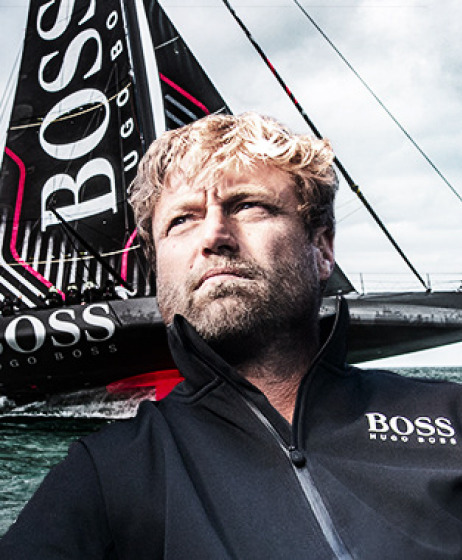

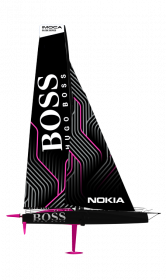

In [50]:
display(Image(df_boat.loc[30]['URL Photo Skipper']), Image(df_boat.loc[30]['URL Icône bateau']))

### Display trajectoire monde IMOCA

In [ ]:
list_xl_files = os.listdir('./'+DIR_XL)

#sublist_xl = list_xl_files[100:400]
sublist_xl = list_xl_files[:482]

locations_test = np.zeros([len(sublist_xl),2])
idx = 0

for xl_file in sublist_xl:
    #print(f'reading : {xl_file} ')
    df_loc_test = pd.read_excel('./'+DIR_XL+xl_file, usecols='B,C,F:U', skiprows=5, skipfooter=4, header=None, names=col_names, converters=dico_conv)
    df_loc_test.set_index('Numéro Voile', inplace=True)
    locations_test[idx] = [df_loc_test.loc[59]['Latitude'], df_loc_test.loc[59]['Longitude']]
    idx += 1
    if idx%100 == 0:
        print(f'Avancement : {idx} / {len(sublist_xl)}')



Avancement : 100 / 482
Avancement : 200 / 482
Avancement : 300 / 482
Avancement : 400 / 482


In [263]:
import copy

#center = (21.828669, -170.965253)
center = (locations_test[150,0], locations_test[150,1])

locations_test_modif = copy.deepcopy(locations_test)
#locations_test_modif[locations_test_modif[:1]<0] += 180

map_ant = Map(basemap=basemaps.Esri.NatGeoWorldMap, zoom=2, dragging=True, world_copy_jump=True)

ant_path = AntPath(
    locations=locations_test_modif.tolist(),
    dash_array=[1, 20],
    delay=200,
    color='#030aa7',
    pulse_color='#d7fffe',
    weight=7
)

map_ant.add_layer(ant_path)

map_ant

Map(center=[0.0, 0.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

## Refine XL creation

In [ ]:
DIR_XL = 'dir_excel'
DIR_XL in os.listdir()

tag_xl = '20201109_110000.xlsx'

excel_app = xw.App(visible=False)

url_xl = 'https://www.vendeeglobe.org/download-race-data/vendeeglobe_'+tag_xl
r_xl = requests.get(url_xl)
open(DIR_XL+tag_xl, 'wb').write(r_xl.content)
excel_book = excel_app.books.open(DIR_XL+tag_xl)
excel_book.save()
excel_book.close()

excel_app.quit()

FileNotFoundError: [Errno 2] No such file or directory: 'test_excel//20201109_110000.xlsx'

url_test = df_boat.loc[25]['url_skipper']


res_skipper = requests.get(url_test)
soup_skipper = BeautifulSoup(res_skipper.content, 'html.parser')


skipper_nat = soup_skipper.find(class_="skipper-datalist__item m--nationality").find(class_="skipper-datalist__value__text").text
print(f'Nationalité : {skipper_nat}')

skipper_age = soup_skipper.find(class_="icon icon-calendar").find_parent("p").find(class_="skipper-datalist__value__text").text.split()[0]
print(f'Age : {skipper_age}')

skipper_particip = soup_skipper.find(class_="skipper-participation__number").find("span").text
print(f'Nb. participations : {skipper_particip}')

palma_an = '2018'
skipper_palmares = soup_skipper.find(class_='prizes-slider__year',text=palma_an).find_parent('div').find(class_='prizes-slider__list l-unlist').text.split('\r\n')
print(f'Palmares {palma_an} : {len(skipper_palmares)-1} trophées - {skipper_palmares}')

skipper_all_palmares = soup_skipper.find_all(class_='prizes-slider__year')

cpt_palma = 0
for year in skipper_all_palmares:
    list_palma_y = year.find_parent('div').find(class_='prizes-slider__list l-unlist').text.split('\r\n')
    cpt_palma += len(list_palma_y) - 1

print(f'Palmares total : {cpt_palma} trophées')



url_img_skipper = soup_skipper.find(class_='skipper-hero__figure__img svg-filter').image['xlink:href']
print(f'URL image skipper : {url_img_skipper}')
